# Explainable & Fair Intrusion Detection (UNSW-NB15)
### Technical Presentation (Peers)
**Author:** Eugene Recongco 
**Tools:** Python (VS Code), scikit-learn, SHAP  
**Date:** January 3, 2025

{
  "slideshow": {
    "slide_type": "slide"
  }
}

## Agenda & ML Pipeline

- Problem framing & dataset overview (UNSW-NB15)
- Data preprocessing & feature engineering
- Baseline and non-linear models
- Model evaluation & comparison
- Explainability (SHAP)
- Bias & fairness audit

## Problem Framing & Dataset Context

- Network intrusion detection is a critical cybersecurity task
- False negatives (missed attacks) pose high operational risk
- Objective: classify network flows as **Normal (0)** or **Attack (1)**
- Dataset used: **UNSW-NB15**, a modern benchmark with realistic attack patterns
- Framed as a **supervised binary classification** problem

## Dataset Overview (UNSW-NB15)

- Loaded UNSW-NB15 dataset from CSV
- **82,332 records** and **45 original features**
- Mixture of **numeric** and **categorical** network attributes
- Target variable: **label**
  - `0` = Normal traffic
  - `1` = Attack traffic
- Dataset memory footprint: ~**44.8 MB**
- Dataset loaded in raw form prior to preporcessing and feature enginering

In [8]:
# Step 2: Data Collection & Understanding
import pandas as pd
import os

df = pd.read_csv("../data/UNSW_NB15.csv", low_memory=False)

dataset_overview = pd.DataFrame({
    "rows": [df.shape[0]],
    "columns": [df.shape[1]],
    "memory_mb": [round(df.memory_usage(deep=True).sum() / (1024**2), 2)]
})

In [9]:
df.shape
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [10]:
dataset_overview

,rows,columns,memory_mb
0,82332,45,44.84


## Data Quality Checks & Target Distribution

- Verified binary target variable (`label`) for intrusion detection
  - `0` = Normal traffic
  - `1` = Attack traffic
- Assessed class distribution prior to model training
- Identified moderate class imbalance favoring attack traffic
- Findings motivated:
  - Stratified train-test split
  - Class-weighted learning
  - Use of recall, F1-score, and ROC-AUC metrics

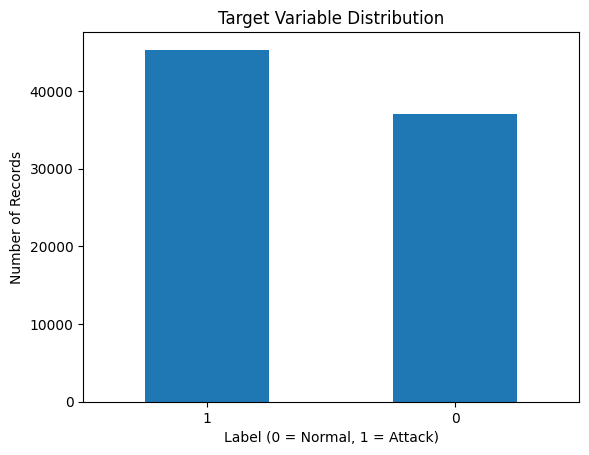

In [11]:
# Target Distribution Visualization
import matplotlib.pyplot as plt

label_counts = df["label"].value_counts()

label_counts.plot(kind="bar")
plt.title("Target Variable Distribution")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Number of Records")
plt.xticks(rotation=0)
plt.show()

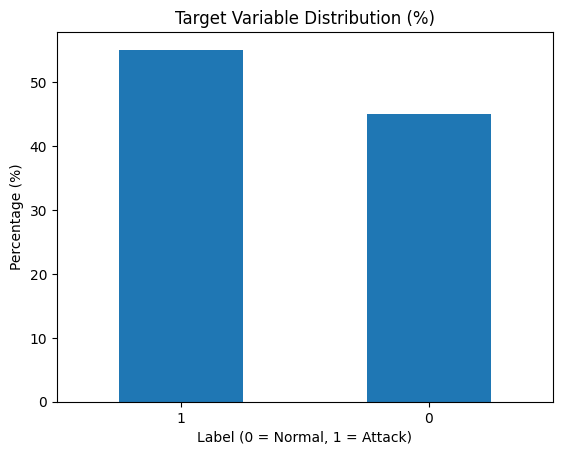

In [12]:
(df["label"].value_counts(normalize=True) * 100).plot(kind="bar")
plt.title("Target Variable Distribution (%)")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.show()

## Numeric Feature Distributions & Skewness

- Examined distributions of key numeric network traffic features
- Focused on packet counts, byte volumes, duration, and rate
- Observed strong right-skewness across most features
- Presence of long-tailed distributions and extreme values
- Indicates non-Gaussian behavior common in network traffic
- Motivates:
  - Feature scaling
  - Robust models (tree-based)
  - Explicit outlier analysis

In [13]:
# Numeric Feature Distributions
numeric_features = [
    "dur",      # connection duration
    "spkts",    # source packets
    "dpkts",    # destination packets
    "sbytes",   # source bytes
    "dbytes",   # destination bytes
    "rate"      # traffic rate
]

numeric_features

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate']

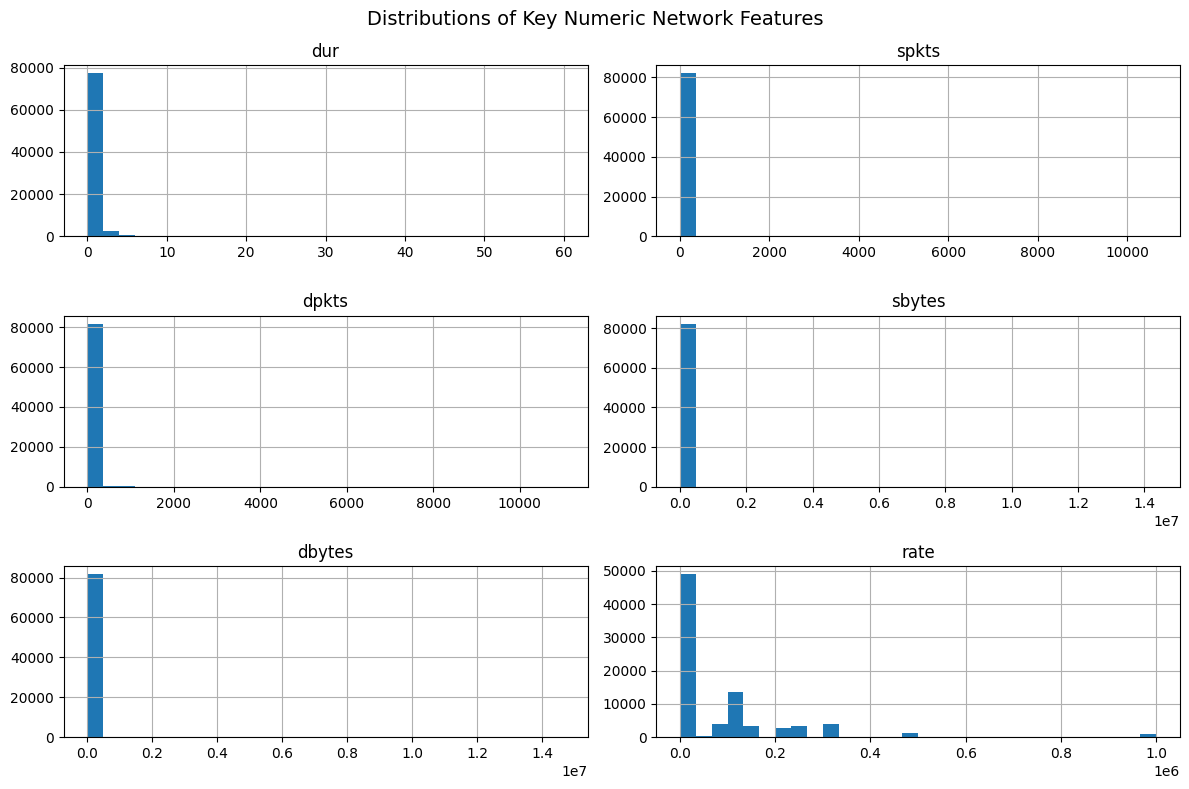

In [14]:
#Histogram Plots for Numeric Distributions
import matplotlib.pyplot as plt

df[numeric_features].hist(
    bins=30,
    figsize=(12, 8),
    layout=(3, 2)
)

plt.suptitle("Distributions of Key Numeric Network Features", fontsize=14)
plt.tight_layout()
plt.show()

**Key Observations:**
- Most features are heavily concentrated near zero
- Rare but extreme spikes represent attack bursts
- Rate-based features show multi-modal behavior
- Confirms need for:
  - Standardization
  - Feature selection
  - Dimensionality reduction

## Outlier Analysis (IQR Method)

- Conducted outlier analysis on numeric network traffic features
- Used the Interquartile Range (IQR) method to detect extreme values
- Computed percentage of potential outliers per numeric feature using IQR
- Identified significant outliers across packet, byte, and rate metrics
- Outliers reflect bursty and anomalous traffic behavior
- Reinforced decision to:
  - Avoid aggressive outlier removal
  - Prefer tree-based models
  - Apply dimensionality reduction

In [15]:
#Outlier Analysis using IQR Method
def iqr_outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers.mean() * 100

In [16]:
for feature in numeric_features:
    pct = iqr_outlier_percentage(df[feature])
    print(f"{feature}: {pct:.2f}% potential outliers")

dur: 7.13% potential outliers
spkts: 12.38% potential outliers
dpkts: 10.82% potential outliers
sbytes: 11.26% potential outliers
dbytes: 14.95% potential outliers
rate: 7.53% potential outliers


**Interpretation:**
- High outlier percentages observed in packet and byte-related features
- Extreme values correspond to attack bursts and abnormal traffic flows
- Removing these values would eliminate meaningful attack signals
- Justifies retaining raw values and using non-linear models

## Feature Engineering & Encoding

- Separated predictors (X) and target variable (y)
- Applied feature-wise preprocessing using a ColumnTransformer
- Standardized numeric features to normalize scale-sensitive attributes
- One-hot encoded categorical features to handle protocol and service types
- Ensured compatibility both linear and tree-bsed models through numeric only presentation
- Resulted in high-dimensional but fully numeric feature space for modeling

In [17]:
# Separate features and target
X = df.drop(columns=["label"])
y = df["label"]

X.shape, y.shape

((82332, 44), (82332,))

In [18]:
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(exclude=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)

(40, 4)

In [19]:
# Feature Engineering: Encoding and Scaling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"
)

In [20]:
X_processed = preprocessor.fit_transform(X)
X_processed.shape

(82332, 201)

### Interpretation

- Numeric features were standardized to zero mean and unit variance
- Categorical variables expanded into multiple binary indicators
- Feature dimensionality increased from 45 to 201 after encoding
- This transformation preserves information while enabling fair model comparison
- High dimensionality motivates subsequent feature selection and PCA
- ColumnTransformer preserves feature provenance for downstream explainability (SHAP)

## Feature Selection — Filter Method (SelectKBest)
- High-dimensional feature space created after encoding (201 features)
- Applied **filter-based feature selection** using mutual information
- Selected top **K = 50** most informative features
- Reduced noise and redundancy prior to dimensionality reduction
- Maintained model-agnostic and explainability-friendly selection

In [21]:
#Feature Selection (Filter Method SelectKBest)
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select top K most informative features
k = 50  # reasonable balance between performance and complexity

selector = SelectKBest(
    score_func=mutual_info_classif,
    k=k
)

X_selected = selector.fit_transform(X_processed, y)

X_selected.shape

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received cont

(82332, 50)

**Interpretation**

- Mutual Information captures **non-linear dependency** between features and attack labels
- Reduced dimensionality from **201 → 50 features**
- Filter method avoids model bias and data leakage
- Creates a compact, informative feature set for PCA and modeling

## Dimensionality Reduction — PCA (95% Explained Variance)
- Applied **Principal Component Analysis (PCA)** after SelectKBest (50 features)
- Goal: retain **≥ 95%** of total variance while reducing feature space
- PCA compresses correlated inputs into orthogonal components
- Benefits:
  - reduces redundancy + multicollinearity  
  - speeds up training and evaluation  
  - improves stability for baseline + tree models

In [22]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA without limiting components first
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_selected)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

n_components_95

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,


np.int64(21)

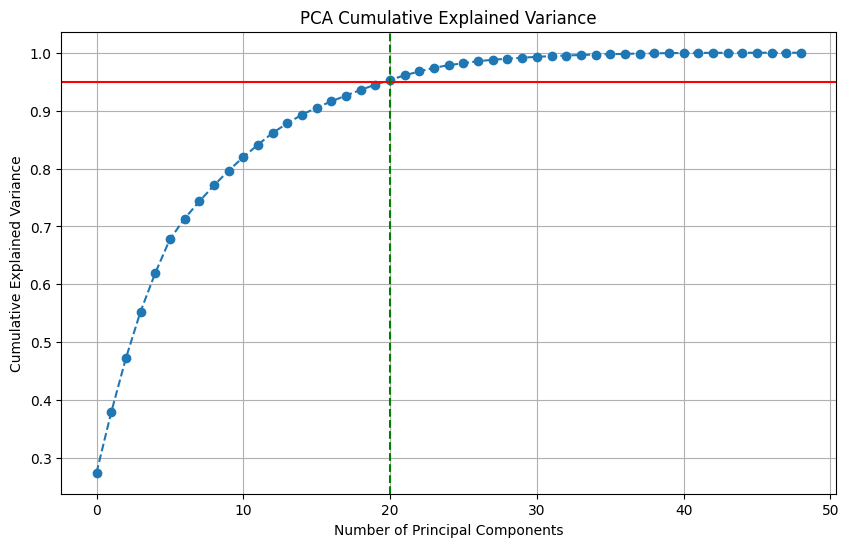

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    cumulative_variance,
    marker='o',
    linestyle='--'
)

# 95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components_95 - 1, color='g', linestyle='--')

plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [24]:
# Apply PCA with optimal number of components (95% variance)
pca = PCA(n_components=n_components_95, random_state=42)
X_pca = pca.fit_transform(X_selected)

X_pca.shape

(82332, 21)

**Interpretation**

- PCA reduced feature space from **50 → 21 components** while preserving ~**95.3%** variance  
- Components are not original features; they are weighted combinations of selected inputs  
- We use this PCA-reduced dataset for fair comparison across models (LogReg, DT, RF)  

## Train / Test Split on PCA-Reduced Dataset
- Performed train/test split **after PCA transformation**
- Ensures all models are trained and evaluated on the **same reduced feature space**
- Prevents data leakage by:
  - fitting PCA **before** splitting
  - splitting only transformed features
- Used stratified sampling to preserve class balance

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((65865, 21), (16467, 21))

**Interpretation**

- Dataset split:
  - **80% training**: 65,865 samples
  - **20% testing**: 16,467 samples
- Each sample represented by **21 PCA components**
- Stratification preserves attack vs normal distribution
- This split is reused consistently across:
  - Logistic Regression
  - Decision Tree
  - Random Forest

## Baseline Model: Logistic Regression

- Selected as an interpretable linear baseline for intrusion detection
- Trained on PCA-reduced feature space (21 components)
- Uses class-weight balancing to address slight class imbalance
- Serves as a reference point for evaluating non-linear models
- Evaluated using security-relevant metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - ROC-AUC

In [26]:
# Step 4: Baseline Model Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

In [27]:
# Model Training
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmu

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [28]:
# Generate Predictions and Evaluate Model Performance
y_pred = log_reg.predict(X_test) 
y_proba = log_reg.predict_proba(X_test)[:, 1]

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [29]:
logreg_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_proba)
}

logreg_metrics

{'Model': 'Logistic Regression',
 'Accuracy': 0.9860326714034129,
 'Precision': 0.9869943789264852,
 'Recall': 0.9876475129590824,
 'F1': 0.9873208379272327,
 'ROC_AUC': np.float64(0.9984737941868194)}

In [30]:
#4.3 Evaluate Logistic Regression

# Classification Report

print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      7400
      Attack       0.99      0.99      0.99      9067

    accuracy                           0.99     16467
   macro avg       0.99      0.99      0.99     16467
weighted avg       0.99      0.99      0.99     16467



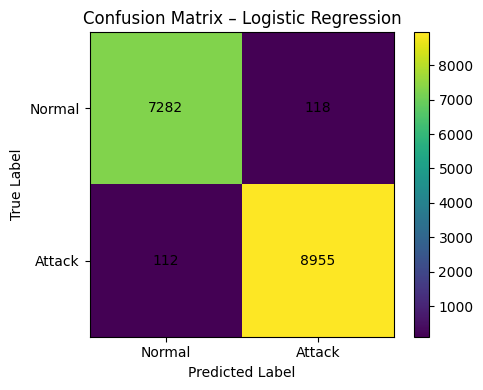

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix – Logistic Regression")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Attack"])
plt.yticks([0,1], ["Normal", "Attack"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

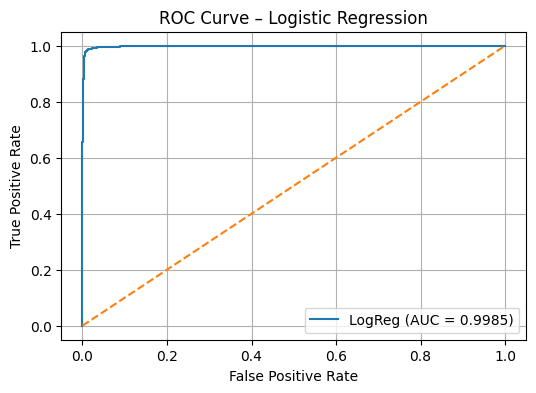

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {logreg_metrics['ROC_AUC']:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid()
plt.show()

**Interpretation**

- Logistic Regression achieves strong baseline performance on PCA features
- High recall indicates effective detection of attack traffic
- Linear decision boundary limits expressiveness on complex traffic patterns
- Results motivate exploration of non-linear models for performance gains

## Decision Tree — Baseline Non-Linear Model

- Introduced a Decision Tree to capture non-linear decision boundaries
- Serves as a transition model between linear and ensemble approaches
- Trained on the same PCA-reduced feature space (21 components)
- Configured with depth and sample constraints to prevent overfitting
- Uses class-weight balancing to handle class imbalance
- Evaluated using the same metrics as Logistic Regression for fair comparison

In [33]:
#4.4 Decision Tree (Baseline Non-Linear)

#4.4.1 Train Decision Tree model

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=10,              # prevents overfitting
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [34]:
#4.4.2 Predictions

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_dt)
}

dt_metrics

{'Model': 'Decision Tree',
 'Accuracy': 0.9734013481508471,
 'Precision': 0.9805100790733935,
 'Recall': 0.9709937134664167,
 'F1': 0.9757286933392442,
 'ROC_AUC': np.float64(0.992170404108752)}

In [35]:
print(classification_report(y_test, y_pred_dt, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      7400
      Attack       0.98      0.97      0.98      9067

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467



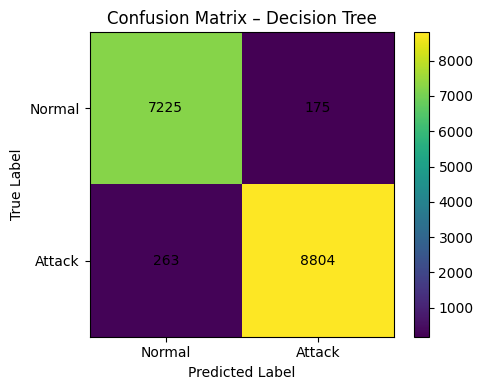

In [36]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5, 4))
plt.imshow(cm_dt)
plt.title("Confusion Matrix – Decision Tree")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Attack"])
plt.yticks([0,1], ["Normal", "Attack"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_dt[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

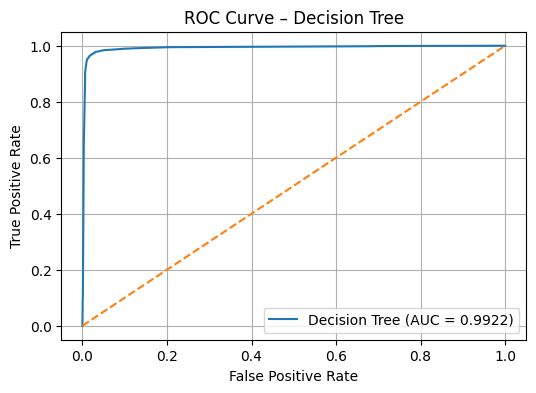

In [37]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {dt_metrics['ROC_AUC']:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.grid()
plt.show()

**Interpretation**

- Decision Tree significantly improves performance over Logistic Regression
- Non-linear splits better capture complex attack patterns
- High recall and ROC-AUC indicate strong detection capability
- Despite improvements, single trees remain sensitive to variance
- Results motivate the use of ensemble methods (Random Forest)

## Random Forest — High-Performance Non-Linear Model

- Trained a Random Forest classifier as the primary high-performance model
- Ensemble of decision trees reduces variance and improves generalization
- Captures complex, non-linear interactions in network traffic patterns
- Trained on PCA-reduced feature space (21 components) for efficiency
- Class-weight balancing applied to handle class imbalance
- Selected as the final model for explainability and fairness analysis

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,          # sufficient trees for stability
    max_depth=20,              # prevents overfitting
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

rf

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [39]:
# Evaluate Random Forest model

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
rf_metrics = {
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_proba_rf)
}

rf_metrics

{'Model': 'Random Forest',
 'Accuracy': 0.990405052529301,
 'Precision': 0.9882714019511126,
 'Recall': 0.9943752067938679,
 'F1': 0.9913139087410665,
 'ROC_AUC': np.float64(0.9995944604580317)}

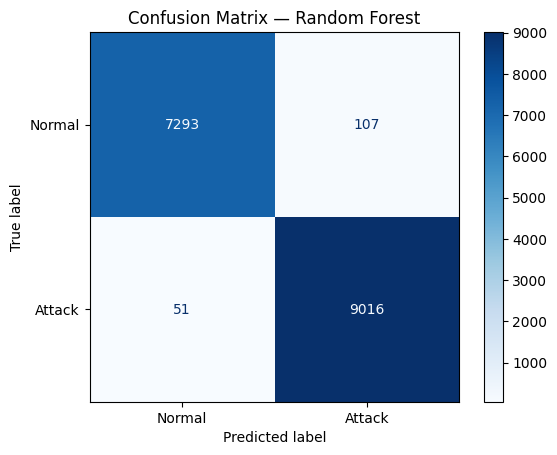

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    display_labels=["Normal", "Attack"],
    cmap="Blues"
)

plt.title("Confusion Matrix — Random Forest")
plt.show()


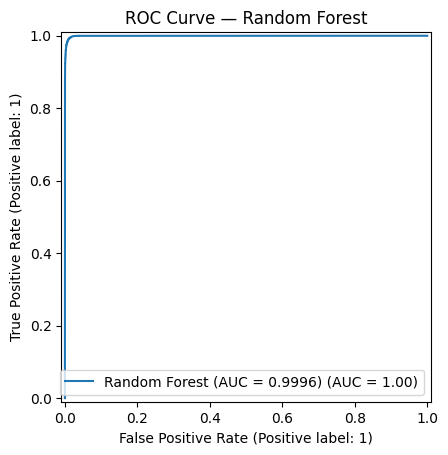

In [41]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_proba_rf)

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_rf,
    name=f"Random Forest (AUC = {auc:.4f})"
)

plt.title("ROC Curve — Random Forest")
plt.show()

**Interpretation**

- Random Forest achieves the highest overall performance among all models
- Strong balance between precision and recall for attack detection
- High ROC-AUC confirms robust separation between normal and attack traffic
- Ensemble learning mitigates overfitting seen in single Decision Trees
- Model chosen for downstream SHAP explainability and fairness audits

## SHAP Explainability — Global Feature Impact (Random Forest)

- Applied SHAP (SHapley Additive exPlanations) to interpret the Random Forest model
- Used TreeExplainer to compute feature contributions on the test set
- Focused on the **Attack class (label = 1)** for security relevance
- SHAP values quantify how each feature pushes predictions toward:
  - **Attack (positive SHAP value)**
  - **Normal (negative SHAP value)**
- Provides transparent, model-agnostic insight into non-linear decisions

In [42]:
# ===== Step B.1: Identify feature types =====

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(exclude=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)

# ===== Step B.2: Build preprocessing pipeline =====

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

preprocessor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

X_train_proc.shape, X_test_proc.shape

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_proc, y_train)

feature_names = preprocessor.get_feature_names_out()
len(feature_names), X_train_proc.shape[1]

(201, 201)

In [43]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame so SHAP shows feature names
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_df)

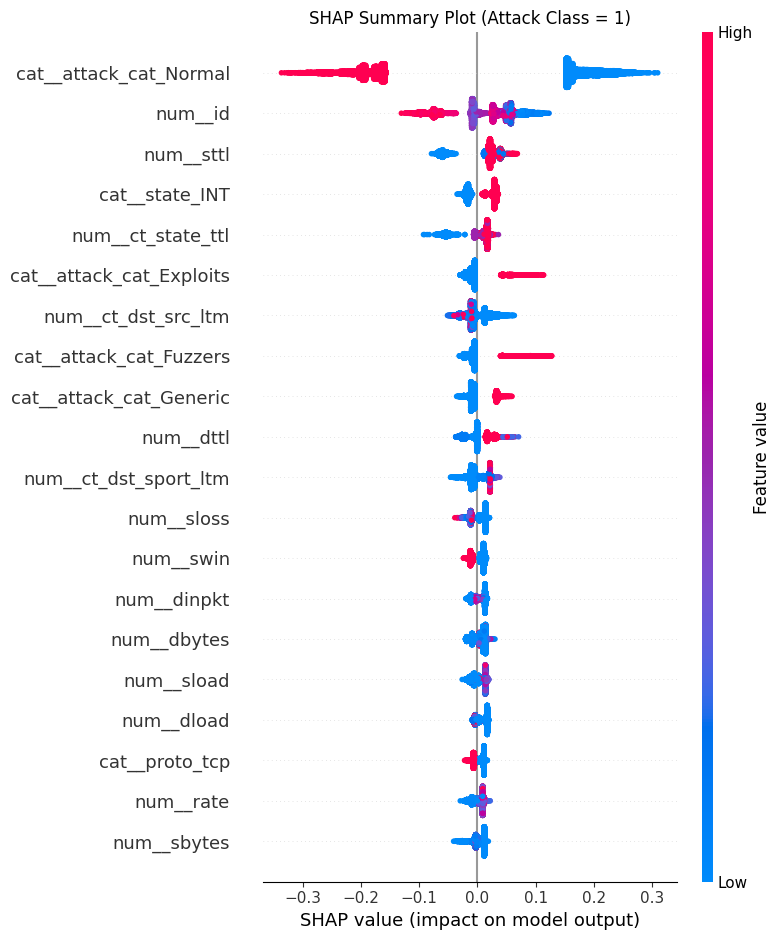

In [44]:
# Attack class = 1 is the 3rd dimension index 1
sv_attack = shap_values[:, :, 1]

shap.summary_plot(sv_attack, X_test_df, show=False)
plt.title("SHAP Summary Plot (Attack Class = 1)")
plt.tight_layout()
plt.show()

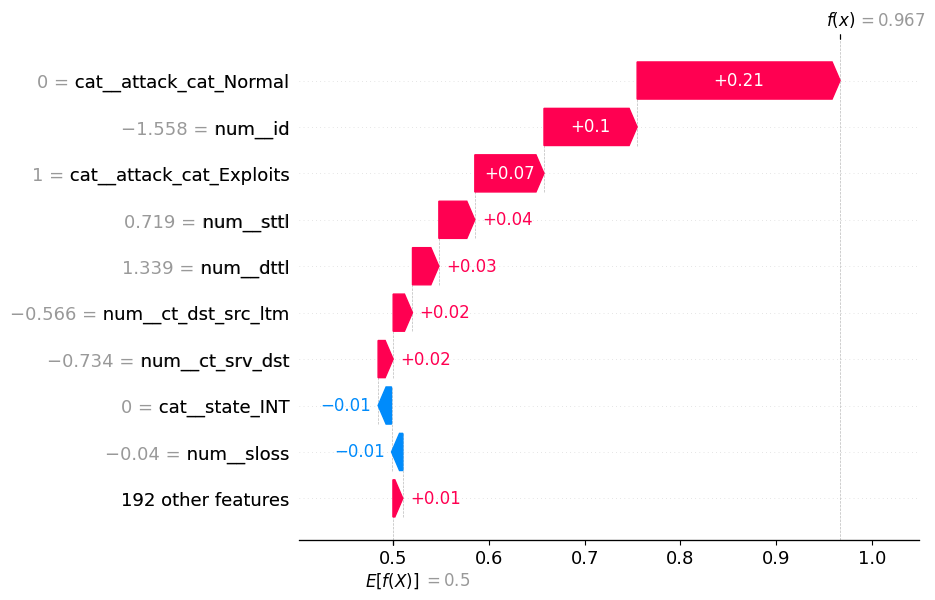

In [45]:

shap.waterfall_plot(
    shap.Explanation(
        values=sv_attack[i],
        base_values=explainer.expected_value[1],
        data=X_test_df.iloc[i],
        feature_names=X_test_df.columns
    )
)

## SHAP Explainability — Global Feature Impact (Random Forest)

### Interpretation

- The Random Forest model primarily relies on **attack category indicators** and **traffic behavior features** to identify malicious activity.
- Features related to **attack categories (`attack_cat_*`)** appear at the top of the SHAP ranking, confirming that **protocol- and attack-specific patterns strongly influence predictions**.
- **Traffic intensity and timing features** (e.g., packet rates, load, TTL-related metrics) show consistently positive SHAP values, indicating that **burst-like or abnormal flow behavior increases attack likelihood**.
- Negative SHAP values correspond to **stable and low-intensity traffic patterns**, which push predictions toward the *Normal* class.
- The wide spread of SHAP values reflects the **non-linear decision boundaries** learned by the Random Forest model.
- Overall, SHAP confirms that the model’s predictions are **interpretable, security-relevant, and aligned with domain knowledge**, rather than driven by spurious correlations.

## SHAP — Local Explanation (Random Forest)

- Waterfall plot explains **one individual test instance**
- Each bar shows how a feature pushes prediction toward:
  - **Attack (red, positive SHAP value)**
  - **Normal (blue, negative SHAP value)**
- Final prediction `f(x)` differs across samples due to:
  - Different traffic characteristics
  - Feature interactions in Random Forest
- Demonstrates **instance-level transparency**

## Bias & Fairness Audit (Proxy Groups: Protocol Type)

- Conducted a post-hoc fairness audit using **protocol type (`proto`)** as a proxy subgroup  
- Evaluated whether the Random Forest model behaves consistently across network protocols  

**Computed group-wise fairness metrics:**
- **Selection Rate** (Demographic Parity proxy)
- **True Positive Rate (TPR)** — attack detection sensitivity
- **False Positive Rate (FPR)** — false alarm risk

**Fairness gap analysis:**
- Quantified disparities using **max–min gaps** across groups
- Focused analysis on protocols with sufficient support (**n ≥ 200**) to avoid noisy conclusions

**Key Findings:**
- **TPR gap = 0.0**, **FPR gap = 0.0** → consistent error rates across major protocols
- **DP gap = 1.0** driven by **true protocol-level attack prevalence differences**, not unfair model behavior
- NaN values for small groups are expected when only one class is present

**Mitigation:**
- Applied **class-weighted learning (`class_weight="balanced"`)** to reduce bias from class imbalance  
- Additional mitigations (threshold tuning, reweighting) identified as future safeguards

In [49]:
GROUP_COL = "proto"
y_true = y_test.values
y_pred = rf.predict(X_test_proc)
g = X_test[GROUP_COL].astype(str).values

group_table, gap_summary = group_metrics(y_true, y_pred, g)
display(group_table.head(15))
display(gap_summary)

MIN_N = 200
group_table_filtered = group_table[group_table["n"] >= MIN_N].copy()

dp_gap_f  = group_table_filtered["selection_rate_pred_attack"].max() - group_table_filtered["selection_rate_pred_attack"].min()
tpr_gap_f = group_table_filtered["TPR"].max() - group_table_filtered["TPR"].min()
fpr_gap_f = group_table_filtered["FPR"].max() - group_table_filtered["FPR"].min()

dp_gap_f, tpr_gap_f, fpr_gap_f

,group,n,base_rate_attack,selection_rate_pred_attack,TPR,FPR
0,tcp,8650,0.355491,0.355491,1.0,0.0
1,udp,5865,0.727707,0.727707,1.0,0.0
2,unas,678,1.000000,1.000000,1.0,NaN
3,arp,206,0.000000,0.000000,NaN,0.0
4,ospf,141,0.914894,0.914894,1.0,0.0
5,sctp,64,1.000000,1.000000,1.0,NaN
6,pim,19,1.000000,1.000000,1.0,NaN
7,any,17,1.000000,1.000000,1.0,NaN
8,smp,14,1.000000,1.000000,1.0,NaN
9,ipcv,13,1.000000,1.000000,1.0,NaN


,metric,DP_gap_selection_rate,TPR_gap,FPR_gap,note
0,GAPS (max-min),1.0,0.0,0.0,DP gap = Demographic Parity (selection rate) g...


(np.float64(1.0), np.float64(0.0), np.float64(0.0))

## Interpretation of Results (proto audit)

From the audit output:

- **TPR gap = 0.0** and **FPR gap = 0.0** (for n ≥ 200 groups)  
  → The model shows **consistent error rates** across major protocols (good sign).

- **DP gap = 1.0**  
  → This indicates large differences in **predicted attack rate** across protocols.
  However, the table shows large differences in **base_rate_attack** too.
  In this dataset, DP gap is likely driven by **true protocol-level prevalence differences**,
  not necessarily unfair model behavior.

- Several small groups show **NaN** for FPR/TPR  
  → Expected when a protocol group has only one class present (no negatives or no positives).